#Deep Learning TAU -Home Work 2 - Practical 

## General Setup
This section includes general/pre-code part

1. Mount the drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
folderpath = '/content/drive/My Drive/ex2_300746930_034915504/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


2. Install and import libs

In [0]:
!pip install numpy torch matplotlib tabulate 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import collections
import os
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import time
import torch
import matplotlib.pyplot as plt
from tabulate import tabulate

3. Pre-proccecing functions

This part is based on https://github.com/deeplearningathome/pytorch-language-model

In [0]:
def _read_words(filename):
  with open(filename, "r") as f:
    return f.read().replace("\n", "<eos>").split()


def _build_vocab(filename):
  data = _read_words(filename)

  counter = collections.Counter(data)
  count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

  words, _ = list(zip(*count_pairs))
  word_to_id = dict(zip(words, range(len(words))))
  id_to_word = dict((v, k) for k, v in word_to_id.items())

  return word_to_id, id_to_word


def _file_to_word_ids(filename, word_to_id):
  data = _read_words(filename)
  return [word_to_id[word] for word in data if word in word_to_id]


def ptb_raw_data(data_path=None, prefix="ptb"):
  train_path = os.path.join(data_path, prefix + ".train.txt")
  valid_path = os.path.join(data_path, prefix + ".valid.txt")
  test_path = os.path.join(data_path, prefix + ".test.txt")

  word_to_id, id_2_word = _build_vocab(train_path)
  train_data = _file_to_word_ids(train_path, word_to_id)
  valid_data = _file_to_word_ids(valid_path, word_to_id)
  test_data = _file_to_word_ids(test_path, word_to_id)
  return train_data, valid_data, test_data, word_to_id, id_2_word


def ptb_iterator(raw_data, batch_size, num_steps):
  """Iterate on the raw PTB data.
  This generates batch_size pointers into the raw PTB data, and allows
  minibatch iteration along these pointers.
  Args:
    raw_data: one of the raw data outputs from ptb_raw_data.
    batch_size: int, the batch size.
    num_steps: int, the number of unrolls.
  Yields:
    Pairs of the batched data, each a matrix of shape [batch_size, num_steps].
    The second element of the tuple is the same data time-shifted to the
    right by one.
  Raises:
    ValueError: if batch_size or num_steps are too high.
  """
  raw_data = np.array(raw_data, dtype=np.int32)
  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len], dtype=np.int32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1)]
  epoch_size = (batch_len - 1) // num_steps
  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")
  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

# Hyper-parameters

In [0]:
hidden_size = 200
embedding_dim = 400
num_steps = 200
batch_size = 5
num_layers = 1
dp_keep_prob = 0.5
inital_lr = 0.001
SGDlr = 0.1
eWithdropout = 100 #number of epochs for dropout models
toSGD = 20 # after eWithdropout/toSGD switch to Adam 
ewitoutdo = 100 #number of epochs for non-dropout models
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device != "cpu":
  print("GPU is available")
else:
  print("Work on CPU")
raw_data = ptb_raw_data(folderpath + 'PTB/')
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('Vocabluary size: {}'.format(vocab_size))

GPU is available
Vocabluary size: 10000


## Word prediction models - classes
- here the dropout apllied only on the LSTM layers

In [0]:
class LSTMDrop(nn.Module):
  """LSMT-based word prediction model with dropout"""
  def __init__(self, embedding_dim,hidden_size, num_steps, batch_size, vocab_size, num_layers, dp_keep_prob):
    super(LSTMDrop, self).__init__()
    if num_layers == 1:
      rdp = 1
    else:
      rdp =  dp_keep_prob
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.num_steps = num_steps
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.dp_keep_prob = dp_keep_prob
    self.num_layers = num_layers
    self.dropout = nn.Dropout(1 - dp_keep_prob)
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=1-rdp)
    self.fc = nn.Linear(in_features=hidden_size,
                           out_features=vocab_size)
    # self.init_weights()

  def init_weights(self):
    init_range = 0.05
    self.word_embeddings.weight.data.uniform_(-init_range, init_range)
    self.fc.bias.data.fill_(0.0)
    self.fc.weight.data.uniform_(-init_range, init_range)

  def init_hidden(self):
    weight = next(self.parameters()).data
    return (Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()),
            Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()))

  def forward(self, inputs, hidden):
    embeds = self.word_embeddings(inputs)
    embeds = self.dropout(embeds)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out)
    logits = self.fc(lstm_out.view(-1, self.hidden_size))
    out = logits.view(self.num_steps, self.batch_size, self.vocab_size)
    # out =  F.log_softmax(out, dim=1) # comment this line to disable softmax
    return out, hidden


In [0]:
class LSTMnoReg(nn.Module):
  """LSMT-based word prediction model"""
  def __init__(self, embedding_dim,hidden_size, num_steps, batch_size, vocab_size, num_layers):
    super(LSTMnoReg, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.num_steps = num_steps
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers)
    self.fc = nn.Linear(in_features=hidden_size,
                           out_features=vocab_size)
    # self.init_weights()

  def init_weights(self):
    init_range = 0.05
    self.word_embeddings.weight.data.uniform_(-init_range, init_range)
    self.fc.bias.data.fill_(0.0)
    self.fc.weight.data.uniform_(-init_range, init_range)

  def init_hidden(self):
    weight = next(self.parameters()).data
    return (Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()),
            Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()))

  def forward(self, inputs, hidden):
    embeds = self.word_embeddings(inputs)
    lstm_out, hidden = self.lstm(embeds, hidden)
    logits = self.fc(lstm_out.view(-1, self.hidden_size))
    out = logits.view(self.num_steps, self.batch_size, self.vocab_size)
    # out =  F.log_softmax(out, dim=1) # comment this line to disable softmax
    return out, hidden


In [0]:
class GRUDrop(nn.Module):
  """GRU-based word prediction model with dropout"""
  def __init__(self, embedding_dim,hidden_size, num_steps, batch_size, vocab_size, num_layers, dp_keep_prob):
    super(GRUDrop, self).__init__()
    if num_layers == 1:
      rdp = 1
    else:
      rdp =  dp_keep_prob
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.num_steps = num_steps
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.dp_keep_prob = dp_keep_prob
    self.num_layers = num_layers
    self.dropout = nn.Dropout(1 - dp_keep_prob)
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout = 1 - rdp)
    self.fc = nn.Linear(in_features=hidden_size,
                           out_features=vocab_size)
    # self.init_weights()

  def init_weights(self):
    init_range = 0.05
    self.word_embeddings.weight.data.uniform_(-init_range, init_range)
    self.fc.bias.data.fill_(0.0)
    self.fc.weight.data.uniform_(-init_range, init_range)

  def init_hidden(self):
    weight = next(self.parameters()).data
    return (Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()))

  def forward(self, inputs, hidden):
    embeds = self.word_embeddings(inputs)
    embeds = self.dropout(embeds)
    gru_out, hidden = self.gru(embeds, hidden)
    gru_out = self.dropout(gru_out)
    logits = self.fc(gru_out.view(-1, self.hidden_size))
    out = logits.view(self.num_steps, self.batch_size, self.vocab_size)
    # out =  F.log_softmax(out, dim=1) # comment this line to disable softmax
    return out, hidden

In [0]:
class GRUnoReg(nn.Module):
  """GRU-based word prediction model"""
  def __init__(self, embedding_dim,hidden_size, num_steps, batch_size, vocab_size, num_layers):
    super(GRUnoReg, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.num_steps = num_steps
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.num_layers = num_layers
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers)
    self.fc = nn.Linear(in_features=hidden_size,
                           out_features=vocab_size)
    # self.init_weights()

  def init_weights(self):
    init_range = 0.05
    self.word_embeddings.weight.data.uniform_(-init_range, init_range)
    self.fc.bias.data.fill_(0.0)
    self.fc.weight.data.uniform_(-init_range, init_range)

  def init_hidden(self):
    weight = next(self.parameters()).data
    return Variable(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_())

  def forward(self, inputs, hidden):
    embeds = self.word_embeddings(inputs)
    gru_out, hidden = self.gru(embeds, hidden)
    
    logits = self.fc(gru_out.view(-1, self.hidden_size))
    out = logits.view(self.num_steps, self.batch_size, self.vocab_size)
    # out =  F.log_softmax(out, dim=1) # comment this line to disable softmax
    return out, hidden


##Training and Evaluation Function for a single epoch

In [0]:
def run_epoch(model, data,optimizer=False, is_train=False, lr=1.0,NetType = "LSTM"):
  """Runs the model on the given data."""
  if is_train:
    model.train()
  else:
    model.eval()
  epoch_size = ((len(data) // model.batch_size) - 1) // model.num_steps
  start_time = time.time()
  hidden = model.init_hidden()
  costs = 0.0
  iters = 0
  for iteration, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.num_steps)):
    inputs = Variable(torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous()).to(device)
    model.zero_grad()
    if (NetType == "GRU"):
      hidden = hidden.data
    else:
      hidden = tuple([each.data for each in hidden])
    outputs, hidden = model(inputs, hidden)
    targets = Variable(torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous()).to(device)
    tt = torch.squeeze(targets.view(-1, model.batch_size * model.num_steps))
    loss = criterion(outputs.view(-1, model.vocab_size), tt)
    costs += loss.item()
    iters += 1
    if is_train:
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 10)
      optimizer.step()
  del loss
  return np.exp((costs / iters))

# Training Scripts

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_perplexity: 587.381, valid_perplexity: 573.848
>> epoch: 2, train_perplexity: 478.694, valid_perplexity: 468.075
>> epoch: 3, train_perplexity: 428.785, valid_perplexity: 420.979
>> epoch: 4, train_perplexity: 397.160, valid_perplexity: 391.505
>> epoch: 5, train_perplexity: 374.084, valid_perplexity: 370.198
++++++++++++++++++++++++++ Switching to Adam++++++++++++++++++++++++++
>> epoch: 6, train_perplexity: 224.187, valid_perplexity: 246.929
>> epoch: 7, train_perplexity: 171.790, valid_perplexity: 202.509
>> epoch: 8, train_perplexity: 143.433, valid_perplexity: 177.897
>> epoch: 9, train_perplexity: 125.758, valid_perplexity: 163.628
>> epoch: 10, train_perplexity: 113.613, valid_perplexity: 154.471
>> epoch: 11, train_perplexity: 104.471, valid_perplexity: 147.429
>> epoch: 12, train_perplexity: 97.173, valid_perplexity: 141.958
>> epoch: 13, train_perplexity: 91.757, valid_perplexity: 138.412
>> epo

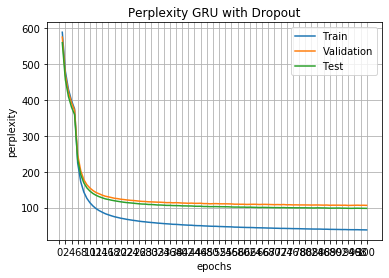

In [0]:
"""
Script for GRU with Dropout training
"""
num_epochs = eWithdropout
model = GRUDrop(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers, dp_keep_prob=dp_keep_prob)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr)
ValidPrepGRUdrop = 10000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
      print("++++++++++++++++++++++++++ Switching to Adam++++++++++++++++++++++++++")
      del optimizer
      optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epoch(model, train_data,optimizer, True,NetType = "GRU")
  with torch.no_grad():
    train_p = run_epoch(model, train_data,optimizer, False,NetType = "GRU") # present without the dropout
    valid_p = run_epoch(model, valid_data,optimizer,NetType = "GRU")
    test_p = run_epoch(model, test_data,optimizer,NetType = "GRU")
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidPrepGRUdrop > valid_p:
    GRUdropmodel = model
    TrainPrepGRUdrop = train_p
    ValidPrepGRUdrop = valid_p
    TestPrepGRUdrop = test_p
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------- best model saved ----------------------------')
  else:
    cntr += 1
    if cntr == 5:
      num_epochs = epoch + 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
    
  print('>> epoch: {}, train_perplexity: {:.3f}, valid_perplexity: {:.3f}'.format(epoch+1, train_p,valid_p))           
print("++++++++++++++++++++++++++ Testing ++++++++++++++++++++++++++")
# model.batch_size = 1 # to make sure we process all the data

print('Test Perplexity: {:.2f}'.format(TestPrepGRUdrop))
print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
torch.save(GRUdropmodel.state_dict(), folderpath+'models/GRUdrop.pkl')
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
plt.plot(range(1,num_epochs+1),ValidP, label = 'Validation')
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('perplexity')
plt.xlabel('epochs')
plt.legend()
plt.title('Perplexity GRU with Dropout')
plt.grid(True)
plt.show()
GRUDropTrain = TrainP
GRUDropVaild = ValidP
GRUDropTest = TestP
del model,optimizer

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_perplexity: 709.886, valid_perplexity: 695.531
>> epoch: 2, train_perplexity: 562.882, valid_perplexity: 551.375
>> epoch: 3, train_perplexity: 500.132, valid_perplexity: 490.946
>> epoch: 4, train_perplexity: 457.810, valid_perplexity: 450.253
>> epoch: 5, train_perplexity: 427.559, valid_perplexity: 421.639
++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++
>> epoch: 6, train_perplexity: 237.263, valid_perplexity: 255.800
>> epoch: 7, train_perplexity: 182.202, valid_perplexity: 209.741
>> epoch: 8, train_perplexity: 155.302, valid_perplexity: 188.009
>> epoch: 9, train_perplexity: 137.755, valid_perplexity: 173.397
>> epoch: 10, train_perplexity: 125.786, valid_perplexity: 163.489
>> epoch: 11, train_perplexity: 116.890, valid_perplexity: 156.620
>> epoch: 12, train_perplexity: 109.783, valid_perplexity: 150.982
>> epoch: 13, train_perplexity: 103.881, valid_perplexity: 146.528
>> 

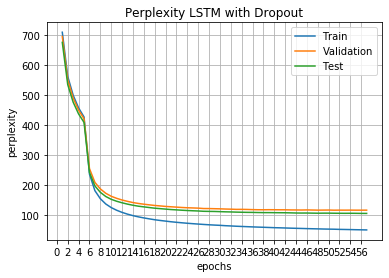

In [0]:
"""
Script for LSTM with Dropout training
"""
num_epochs = eWithdropout
model = LSTMDrop(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers, dp_keep_prob=dp_keep_prob)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr)
ValidPrepLSTMdrop = 1000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
      print("++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++")
      del optimizer
      optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epoch(model, train_data,optimizer, True)
  with torch.no_grad():
    train_p = run_epoch(model, train_data,optimizer, False) # present without the dropout
    valid_p = run_epoch(model, valid_data,optimizer)
    test_p = run_epoch(model, test_data,optimizer)
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidPrepLSTMdrop > valid_p:
    TrainPrepLSTMdrop = train_p
    ValidPrepLSTMdrop = valid_p
    TestPrepLSTMdrop = test_p
    LSTMdropmodel = model
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------- best model saved ----------------------------')
  else:
    cntr += 1
    if cntr == 5:
      num_epochs = epoch+ 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
    
  print('>> epoch: {}, train_perplexity: {:.3f}, valid_perplexity: {:.3f}'.format(epoch+1, train_p,valid_p))           
print("++++++++++++++++++++++++++ Testing ++++++++++++++++++++++++++")
print('Test Perplexity: {:.2f}'.format(TestPrepLSTMdrop))
print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
torch.save(LSTMdropmodel.state_dict(), folderpath + 'models/LSTMdrop.pkl')
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
plt.plot(range(1,num_epochs+1),ValidP, label = 'Validation')
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('perplexity')
plt.xlabel('epochs')
plt.legend()
plt.title('Perplexity LSTM with Dropout')
plt.grid(True)
plt.show()
LSTMDropTrain = TrainP
LSTMDropVaild = ValidP
LSTMDropTest = TestP
del model,optimizer

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_perplexity: 533.408, valid_perplexity: 524.733
>> epoch: 2, train_perplexity: 423.732, valid_perplexity: 418.529
>> epoch: 3, train_perplexity: 374.260, valid_perplexity: 371.758
>> epoch: 4, train_perplexity: 342.339, valid_perplexity: 342.250
>> epoch: 5, train_perplexity: 318.751, valid_perplexity: 320.971
++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++
>> epoch: 6, train_perplexity: 145.567, valid_perplexity: 180.643
>> epoch: 7, train_perplexity: 97.444, valid_perplexity: 146.318
>> epoch: 8, train_perplexity: 75.128, valid_perplexity: 135.344
>> epoch: 9, train_perplexity: 61.685, valid_perplexity: 132.325
------------------- best model saved ----------------------------
>> epoch: 10, train_perplexity: 52.840, valid_perplexity: 133.707
>> epoch: 11, train_perplexity: 46.425, valid_perplexity: 137.155
>> epoch: 12, train_perplexity: 41.489, valid_perplexity: 142.248
>> epoch: 

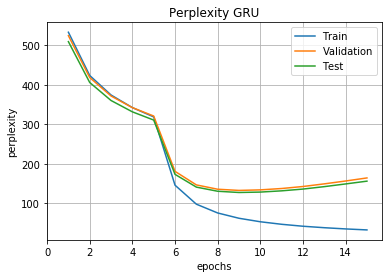

In [0]:
"""
Script for GRU training
"""
num_epochs = ewitoutdo
model = GRUnoReg(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr)
ValidPrepGRU = 1000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
    print("++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++")
    del optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epoch(model, train_data,optimizer, True,NetType = "GRU")
  with torch.no_grad():
    train_p = run_epoch(model, train_data,optimizer, False,NetType = "GRU") # present without the dropout
    valid_p = run_epoch(model, valid_data,optimizer,NetType = "GRU")
    test_p = run_epoch(model, test_data,optimizer,NetType = "GRU")
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidPrepGRU > valid_p:
    TrainPrepGRU = train_p
    ValidPrepGRU = valid_p
    TestPrepGRU = test_p
    GRUmodel = model
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------- best model saved ----------------------------')
  else:
    cntr += 1
    if cntr == 5:
      num_epochs = epoch + 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
    

 
  print('>> epoch: {}, train_perplexity: {:.3f}, valid_perplexity: {:.3f}'.format(epoch+1, train_p,valid_p))           
print("++++++++++++++++++++++++++ Testing ++++++++++++++++++++++++++")
# model.batch_size = 1 # to make sure we process all the data

print('Test Perplexity: {:.2f}'.format(TestPrepGRU))
print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
torch.save(GRUmodel.state_dict(), folderpath+'/models/GRU.pkl')
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
plt.plot(range(1,num_epochs+1),ValidP, label = 'Validation')
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('perplexity')
plt.xlabel('epochs')
plt.legend()
plt.title('Perplexity GRU')
plt.grid(True)
plt.show()
GRUDropTrain = TrainP
GRUDropVaild = ValidP
GRUDropTest = TestP
del model,optimizer

++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++
>> epoch: 1, train_perplexity: 630.279, valid_perplexity: 618.475
>> epoch: 2, train_perplexity: 490.814, valid_perplexity: 482.088
>> epoch: 3, train_perplexity: 427.066, valid_perplexity: 421.143
>> epoch: 4, train_perplexity: 387.163, valid_perplexity: 383.464
>> epoch: 5, train_perplexity: 359.043, valid_perplexity: 357.412
++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++
>> epoch: 6, train_perplexity: 157.621, valid_perplexity: 187.362
>> epoch: 7, train_perplexity: 107.131, valid_perplexity: 150.512
>> epoch: 8, train_perplexity: 83.449, valid_perplexity: 136.743
>> epoch: 9, train_perplexity: 69.124, valid_perplexity: 131.265
>> epoch: 10, train_perplexity: 59.397, valid_perplexity: 130.116
------------------- best model saved ----------------------------
>> epoch: 11, train_perplexity: 52.214, valid_perplexity: 131.539
>> epoch: 12, train_perplexity: 46.720, valid_perplexity: 134.767
>> epoch:

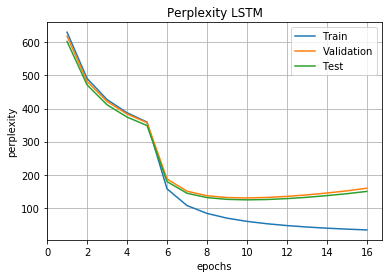

In [0]:
"""
Script for LSTM training
"""
num_epochs = ewitoutdo
model = LSTMnoReg(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = SGDlr)
ValidPrepLSTM = 100000000
flag = 0
cntr = 0
TrainP = []
ValidP = []
TestP = []
print("++++++++++++++++++++++++++ Training ++++++++++++++++++++++++++")
for epoch in range(num_epochs):
  if epoch == int(num_epochs/toSGD):
    print("++++++++++++++++++++++++++ Switching to Adam ++++++++++++++++++++++++++")
    del optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr = inital_lr)
  _ = run_epoch(model, train_data,optimizer, True)
  with torch.no_grad():
    train_p = run_epoch(model, train_data,optimizer, False) # present without the dropout
    valid_p = run_epoch(model, valid_data,optimizer)
    test_p = run_epoch(model, test_data,optimizer)
  TrainP.append(train_p)
  ValidP.append(valid_p)
  TestP.append(test_p)
  if ValidPrepLSTM > valid_p:
    TrainPrepLSTM = train_p
    ValidPrepLSTM = valid_p
    TestPrepLSTM = test_p
    LSTMmodel = model
    cntr = 0
    if flag == 1:
      flag = 0
  elif flag == 0:
    flag = 1
    print('------------------- best model saved ----------------------------')
  else:
    cntr += 1
    if cntr == 5:
      num_epochs = epoch + 1
      print('-------------- over-training !!! Stop Training --------------------')
      break
  print('>> epoch: {}, train_perplexity: {:.3f}, valid_perplexity: {:.3f}'.format(epoch+1, train_p,valid_p))           
print("++++++++++++++++++++++++++ Testing ++++++++++++++++++++++++++")
print('Test Perplexity: {:.2f}'.format(TestPrepLSTM))
print("++++++++++++++++++++++++++ Done! ++++++++++++++++++++++++++")
torch.save(LSTMmodel.state_dict(), folderpath+'/models/LSTM.pkl')
plt.plot(range(1,num_epochs+1),TrainP, label = 'Train')
plt.plot(range(1,num_epochs+1),ValidP, label = 'Validation')
plt.plot(range(1,num_epochs+1),TestP, label = 'Test')
plt.xticks(np.arange(0, num_epochs+1, 2.0))
plt.ylabel('perplexity')
plt.xlabel('epochs')
plt.legend()
plt.title('Perplexity LSTM')
plt.grid(True)
plt.show()
LSTMTrain = TrainP
LSTMVaild = ValidP
LSTMTest = TestP
del model,optimizer

Presenting the data

In [0]:
T = tabulate([['LSTM',TrainPrepLSTM, ValidPrepLSTM,TestPrepLSTM],
              ['GRU',TrainPrepGRU, ValidPrepGRU,TestPrepGRU], 
              ['LSTMDrop',TrainPrepLSTMdrop, ValidPrepLSTMdrop,TestPrepLSTMdrop],
              ['GRUDrop',TrainPrepGRUdrop, ValidPrepGRUdrop,TestPrepGRUdrop]]
             ,headers=['Model', 'Train-Perplexity', 'Validation-Perplexity', 'Test-Perplexity'])
print(T)

Model       Train-Perplexity    Validation-Perplexity    Test-Perplexity
--------  ------------------  -----------------------  -----------------
LSTM                 59.3966                  130.116           124.378
GRU                  61.6851                  132.325           127.072
LSTMDrop             53.7313                  117.11            106.953
GRUDrop              38.8477                  106.195            98.1978


# Load and evaluate trained models

load the models

In [0]:
LSTMdropmodel = LSTMDrop(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers, dp_keep_prob=dp_keep_prob).to(device)
LSTMdropmodel.load_state_dict(torch.load(folderpath+'models/LSTMdrop.pkl'))

LSTMmodel = LSTMnoReg(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers).to(device)
LSTMmodel.load_state_dict(torch.load(folderpath+'models/LSTM.pkl'))

GRUdropmodel = GRUDrop(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers, dp_keep_prob=dp_keep_prob).to(device)
GRUdropmodel.load_state_dict(torch.load(folderpath+'models/GRUdrop.pkl'))


GRUmodel = GRUnoReg(embedding_dim,hidden_size, num_steps=num_steps, batch_size=batch_size,
                vocab_size=vocab_size, num_layers=num_layers).to(device)
GRUmodel.load_state_dict(torch.load(folderpath+'models/GRU.pkl'))



Evaluate The models

In [0]:
optimizer=None
LSTMmodel.batch_size = 1 # to make sure we process all the data
TrainPrepLSTM = run_epoch(LSTMmodel, train_data)
ValidPrepLSTM = run_epoch(LSTMmodel, valid_data)
TestPrepLSTM = run_epoch(LSTMmodel, test_data)
LSTMdropmodel.batch_size = 1
TrainPrepLSTMdrop = run_epoch(LSTMdropmodel, train_data)
TrainPrepLSTMdrop = run_epoch(LSTMdropmodel, valid_data)
TrainPrepLSTMdrop = run_epoch(LSTMdropmodel, test_data)
GRUmodel.batch_size = 1
TrainPrepGRU = run_epoch(GRUmodel, train_data,NetType="GRU")
ValidPrepGRU = run_epoch(GRUmodel, valid_data,NetType="GRU")
TestPrepGRU = run_epoch(GRUmodel, test_data,NetType="GRU")
GRUmodel.batch_size = 1
TrainPrepGRUdrop = run_epoch(GRUdropmodel, train_data,NetType="GRU")
TrainPrepGRUdrop = run_epoch(GRUdropmodel, valid_data,NetType="GRU")
TrainPrepGRUdrop = run_epoch(GRUdropmodel, test_data,NetType="GRU")

In [0]:
T = tabulate([['LSTM',TrainPrepLSTM, ValidPrepLSTM,TestPrepLSTM],
              ['GRU',TrainPrepGRU, ValidPrepGRU,TestPrepGRU], 
              ['LSTMDrop',TrainPrepLSTMdrop, ValidPrepLSTMdrop,TestPrepLSTMdrop],
              ['GRUDrop',TrainPrepGRUdrop, ValidPrepGRUdrop,TestPrepGRUdrop]]
             ,headers=['Model', 'Train-Perplexity', 'Validation-Perplexity', 'Test-Perplexity'])
print(T)